# Notebook Purpose

# Import Dependencies

Dependencies will also compile special loss functions (CUDA implemented Earth Mover's Distance) which is in the `emd/structured_losses` directory.

In [1]:
import numpy as np
from pointcloud_helpers import *

import keras
from keras.losses import MSE
from keras.layers import Lambda, Input, Dense, Conv1D, Conv2D, MaxPooling1D, BatchNormalization, MaxPooling2D, Flatten, Reshape, UpSampling2D, Dropout
from keras.models import Model, Sequential,load_model
from keras import callbacks
from keras import backend as K

config = K.tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

K.clear_session()

Done compiling CUDA scripts


Using TensorFlow backend.


In [2]:
semantic_net = load_model("../data/chair_net_250.h5", custom_objects={ 'emd': emd})
# semantic_net = load_model("../data/latent_decoder_noval.h5", custom_objects={'emd':emd})

In [3]:
# decoder.set_weights(decoder_weights)

In [4]:
decoder = semantic_net.layers[-1].layers[-1]
encoder = semantic_net.layers[-1].layers[-2]

# Check model outputs qualitatively

Note that there are 6 dimensions that can be altered. They map to the semantic parameters in this order:  torso_length, neck_length, neck_rotation, leg_length, tail_length, tail_rotation. As all parameters were normalized prior to training, any value between 0-1 is valid.

In [7]:
chair_ptclouds = np.load("../data/chair_pointclouds.npz")["arr_0"]

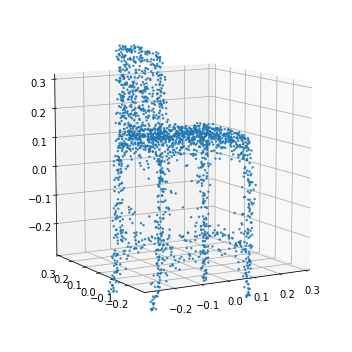

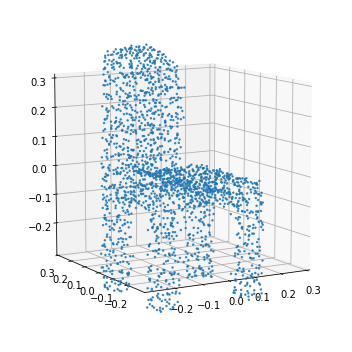

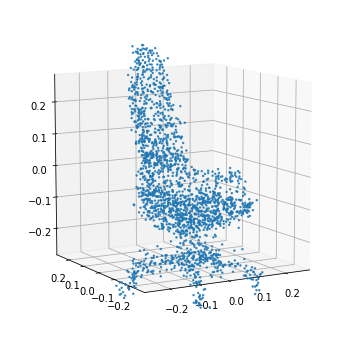

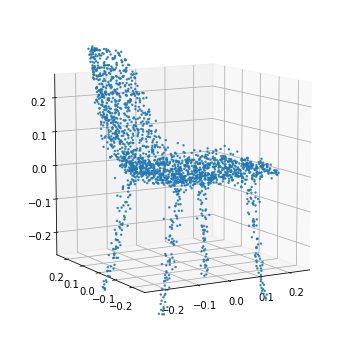

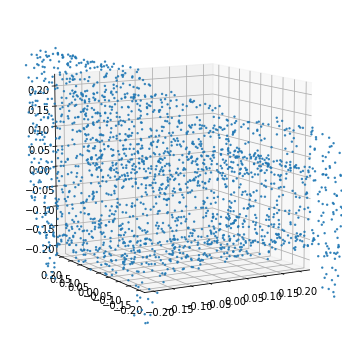

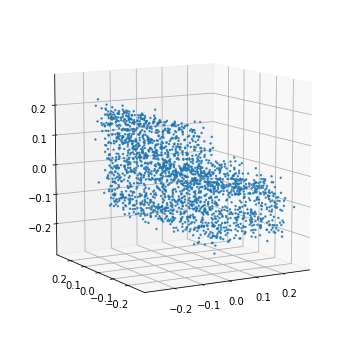

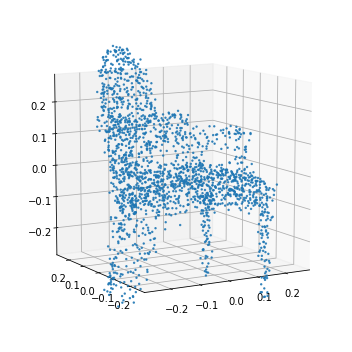

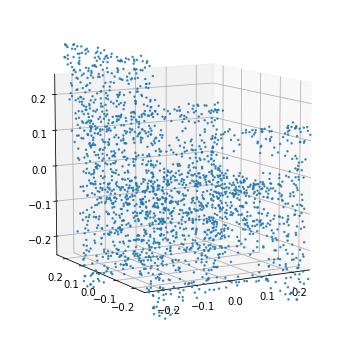

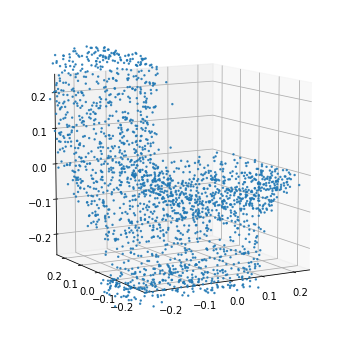

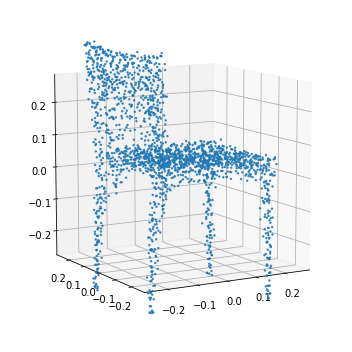

In [17]:
for i in range(10):
    predicted = semantic_net.layers[-1].layers[-2].predict(chair_ptclouds[i].reshape(1,2048,1,3))
    decoded = semantic_net.layers[-1].layers[-1].predict(predicted)
    plot_ptcloud(decoded.reshape(2048,3))

from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
from flask import Flask, send_file, request, jsonify, g
from werkzeug.exceptions import BadRequest
from werkzeug.utils import secure_filename

app = Flask(__name__)
#handles web requests from unity
@app.route('/', methods=["POST"])
def evaluate():
    values = request.form["values"].split('|')
    
    #split the parameter values into something
    values = np.array([float(val) for val in values])
    random_decoded = decoder.predict(values.reshape(1,1,1,23)).reshape(6144)
    
    xyz_string = ",".join([str(pt) for pt in random_decoded.tolist()])

    #return 12 nearest neighbors
    return jsonify(xyz_string)

def run():
    app.run(host='0.0.0.0',port=5000, threaded=False)


In [20]:
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
from flask import Flask, send_file, request, jsonify, g
from werkzeug.exceptions import BadRequest
from werkzeug.utils import secure_filename


run()

# Load Data

# TSNE


from sklearn.manifold import TSNE
tsne3d = TSNE(n_components=3)
tsne3d_trainingdata = tsne3d.fit_transform(encoded_real_training_data.reshape(encoded_real_training_data.shape[0],23)[::3,:])

%matplotlib notebook 
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')

zline = tsne3d_trainingdata[:,0]
xline = tsne3d_trainingdata[:,1]
yline = tsne3d_trainingdata[:,2]
ax.scatter(xline, yline, zline, 'gray')
plt.show()

In [16]:
X = encoded_real_training_data[:,0,0,:]
get_index_for_parameters = {}
for i in range(X.shape[0]):
    get_index_for_parameters[i]= X[i]

In [17]:
get_pointcloud_for_index = {}
for i in range(X.shape[0]):
    get_pointcloud_for_index[i]= real_ptclouds[i]

In [18]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import random
random.seed(1)
nbrs = NearestNeighbors(n_neighbors=4, algorithm='kd_tree').fit(X)



In [19]:
import random
from random import randrange
def yield_direction():

    random_value = (np.random.rand() * 2 ) - 1
    if random_value > 0:
        return 1
    else:
        return -1
def edit_code(code, random_dim, perturbation=0.2, num_params =23):
#     random_dim = np.random.choice(range(num_params))
    direction = yield_direction()
    edit = np.zeros((1, num_params))
    edit[0,random_dim] = direction * perturbation
    return code + edit 

In [21]:
def generate_random_dir(values):
    code = values.reshape((1,23))
    
    random_axes = random.sample(range(23),9)
    random_dir_edits = []
    for axis in random_axes:
        direction = yield_direction()
        
        edited_code = edit_code(code, axis)
        
        predicted = semantic_net.layers[-1].layers[-1].predict(values.reshape((1,1,1,23))).reshape(6144)
        random_dir_edits.append(np.hstack([predicted, edited_code.reshape(23,)]))

    return np.hstack(random_dir_edits)

In [22]:
def generate_random():
    random_codes = np.random.rand(23)
    X_test = np.zeros((1,1,1,23)) + random_codes

    predicted = semantic_net.layers[-1].layers[-1].predict(X_test).reshape(6144)
    return np.hstack([predicted, random_codes])

In [23]:

def run():
    app.run(host='0.0.0.0',port=5000, threaded=False)


In [24]:
#semantic_net2500 channels thrown away 0,3,4,8,16, 19,22
#semantic_net5000 channels thrown away 2,19, 20, 22

In [25]:
slider_values = [(np.percentile(X[:,i],5), np.percentile(X[:,i],95)) for i in range(23)]
import itertools
slider_values = list(itertools.chain(*slider_values))

In [26]:
distances, indices = nbrs.kneighbors(np.random.rand(1,23))

In [27]:
oned_nneighbors = [NearestNeighbors(n_neighbors=4, algorithm='kd_tree').fit(X[:,i:i+1]) for i in range(22)]

In [45]:
app = Flask(__name__)
# pcd = o3d.geometry.PointCloud()
#handles web requests from unity
@app.route('/', methods=["POST"])
def evaluate():
    values = request.form["values"].split('|')
    dimension = int(values[-1:][0])
    
    values = values[:23]
    
    #split the semantic parameter values into array
    values = np.array([[float(val) for val in values]])
    
    output = decoder.predict(values.reshape(1,1,1,23))
    
    output = np.hstack([output.reshape(6144), values.reshape(23)]).reshape(6167)
    
    #now calculate neighborhood
    distances, indices = oned_nneighbors[dimension].kneighbors(values[0,dimension].reshape(1,-1))
    
    neighbors = np.array(X[indices][0])
    match1 = None
    match2 = None
    match3 = None
    
    for key in get_index_for_parameters.keys():
        if np.array_equal(get_index_for_parameters[key],neighbors[0]):
            match1 = key
        if np.array_equal(get_index_for_parameters[key],neighbors[1]):
            match2 = key
        if np.array_equal(get_index_for_parameters[key],neighbors[2]):
            match3 = key

    
    first_match = np.hstack([get_pointcloud_for_index[match1].reshape(6144),get_index_for_parameters[match1]])
    second_match = np.hstack([get_pointcloud_for_index[match2].reshape(6144),get_index_for_parameters[match2]])
    third_match = np.hstack([get_pointcloud_for_index[match3].reshape(6144),get_index_for_parameters[match3]])
    closest_ptclouds = np.vstack([first_match, second_match, third_match]).reshape(3*6167)
    
    
    random_ptclouds_codes = np.hstack([generate_random() for i in range(9)])
    
    
    pointcloud_outputs = np.append(output, closest_ptclouds)
    pointcloud_outputs = np.append(pointcloud_outputs,random_ptclouds_codes)
    
    xyz_string = ",".join([str(pt) for pt in pointcloud_outputs.tolist()])
#     print(xyz_string[0:2000])

    
    #return 12 nearest neighbors
    return jsonify(xyz_string)

In [43]:
app = Flask(__name__)
# pcd = o3d.geometry.PointCloud()
#handles web requests from unity
@app.route('/', methods=["POST"])
def evaluate():
    values = request.form["values"].split('|')
    dimension = int(values[-1:][0])
    
    values = values[:23]
    
    #split the semantic parameter values into array
    values = np.array([[float(val) for val in values]])
    
    output = decoder.predict(values.reshape(1,1,1,23))
    
    output = np.hstack([output.reshape(6144), values.reshape(23)]).reshape(6167)
    
    #now calculate neighborhood
    distances, indices = oned_nneighbors[dimension].kneighbors(values[0,dimension].reshape(1,-1))
    
    neighbors = np.array(X[indices][0])
    match1 = None
    match2 = None
    match3 = None
    
    for key in get_index_for_parameters.keys():
        if np.array_equal(get_index_for_parameters[key],neighbors[0]):
            match1 = key
        if np.array_equal(get_index_for_parameters[key],neighbors[1]):
            match2 = key
        if np.array_equal(get_index_for_parameters[key],neighbors[2]):
            match3 = key

    
    first_match = np.hstack([get_pointcloud_for_index[match1].reshape(6144),get_index_for_parameters[match1]])
    second_match = np.hstack([get_pointcloud_for_index[match2].reshape(6144),get_index_for_parameters[match2]])
    third_match = np.hstack([get_pointcloud_for_index[match3].reshape(6144),get_index_for_parameters[match3]])
    closest_ptclouds = np.vstack([first_match, second_match, third_match]).reshape(3*6167)
    
    
    
    random_ptclouds_codes = generate_random_dir(values)
    
    pointcloud_outputs = np.append(output, closest_ptclouds)
    pointcloud_outputs = np.append(pointcloud_outputs,random_ptclouds_codes)
    
    

    xyz_string = ",".join([str(pt) for pt in pointcloud_outputs.tolist()])
#     print(xyz_string[0:2000])

    
    #return 12 nearest neighbors
    return jsonify(xyz_string)

In [46]:
run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)
172.17.0.1 - - [09/Apr/2021 01:12:34] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:13:20] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:13:36] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:13:36] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:13:36] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:13:36] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:13:37] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:13:43] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:13:43] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:13:43] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:13:43] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:13:44] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:13:44] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:13:55] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:13:55] "POST / HTTP/1.1" 200 -
172.17.0.1 -

172.17.0.1 - - [09/Apr/2021 01:17:48] "POST / HTTP/1.1" 500 -
[2021-04-09 01:17:52,687] ERROR in app: Exception on / [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-45-a9490db96b04>", line 19, in

172.17.0.1 - - [09/Apr/2021 01:18:46] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:18:46] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:18:46] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:18:46] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:18:46] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:18:46] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:18:46] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:18:46] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:18:47] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:19:03] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:19:12] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:19:16] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:19:25] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:19:58] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:19:58] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:19:58] "POST / HTTP/1.1" 200 -
172.17.0

172.17.0.1 - - [09/Apr/2021 01:21:20] "POST / HTTP/1.1" 500 -
172.17.0.1 - - [09/Apr/2021 01:21:38] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:21:46] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:23:10] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:23:11] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:23:11] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:23:11] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:23:11] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:23:11] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:23:11] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:23:11] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:23:11] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:23:11] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:23:11] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:23:11] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:23:11] "POST / HTTP/1.1" 200 -
172.17.0

172.17.0.1 - - [09/Apr/2021 01:24:26] "POST / HTTP/1.1" 500 -
172.17.0.1 - - [09/Apr/2021 01:24:49] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:24:49] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:24:53] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:25:03] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:25:10] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:25:23] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:25:23] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:25:23] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:25:23] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:25:23] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:25:23] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:25:23] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:25:23] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:25:23] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:25:24] "POST / HTTP/1.1" 200 -
172.17.0

172.17.0.1 - - [09/Apr/2021 01:27:33] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:27:33] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:28:12] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:28:12] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:28:12] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:28:12] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:28:12] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:28:12] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:28:12] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:28:12] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:28:12] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:28:12] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:28:13] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:28:13] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:28:13] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:28:13] "POST / HTTP/1.1" 200 -
172.17.0

172.17.0.1 - - [09/Apr/2021 01:28:51] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:28:51] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:28:51] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:28:51] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:28:51] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:28:51] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:28:52] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:28:52] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:28:52] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:28:52] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:28:52] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:28:52] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:28:52] "POST / HTTP/1.1" 200 -
[2021-04-09 01:28:52,542] ERROR in app: Exception on / [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in w

172.17.0.1 - - [09/Apr/2021 01:29:41] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 01:29:41] "POST / HTTP/1.1" 200 -
[2021-04-09 01:29:41,558] ERROR in app: Exception on / [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.vi

172.17.0.1 - - [09/Apr/2021 01:29:58] "POST / HTTP/1.1" 500 -
172.17.0.1 - - [09/Apr/2021 02:02:57] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 02:02:57] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 02:02:57] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 02:02:57] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 02:02:57] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 02:02:57] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 02:02:57] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 02:02:57] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 02:02:57] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 02:02:57] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 02:02:57] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 02:02:58] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 02:02:58] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 02:02:58] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [09/Apr/2021 02:02:58] "POST / HTTP/1.1" 200 -
172.17.0

tsne3d_trainingdata[:2000,][::2].shape

normedtsne3d = tsne3d_trainingdata / max(np.max(abs(tsne3d_trainingdata) ,axis=1))

tsne3d.predict(np.zeros((1,23)))